In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [22]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/BBCA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,4180.0,4220.0,4170.0,4220.0,3802.38208,76474000
1,2017-12-19,4190.0,4250.0,4190.0,4220.0,3802.38208,76553500
2,2017-12-20,4210.0,4210.0,4175.0,4185.0,3770.84668,102963500
3,2017-12-21,4190.0,4230.0,4190.0,4220.0,3802.38208,61100000
4,2017-12-22,4235.0,4335.0,4195.0,4300.0,3874.46582,94573000


In [41]:
# Set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [43]:
df.shape

(1494, 6)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1494 entries, 2017-12-18 to 2023-12-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1494 non-null   float64
 1   High       1494 non-null   float64
 2   Low        1494 non-null   float64
 3   Close      1494 non-null   float64
 4   Adj Close  1494 non-null   float64
 5   Volume     1494 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 81.7 KB


In [45]:
# Check missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [46]:
#MinMaxScaler
ms = MinMaxScaler()
df['Close_ms'] = ms.fit_transform(df[['Close']])


In [47]:
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [48]:
train, test = split_data(df['Close_ms'], 0.9) #90% Train

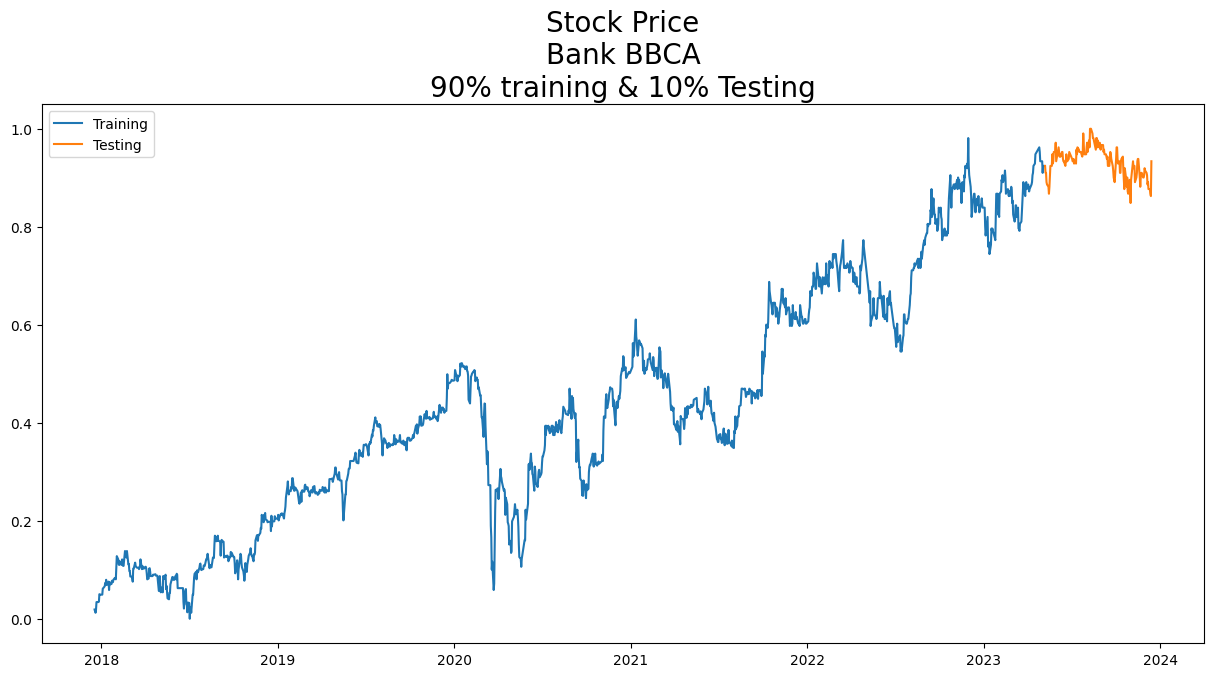

In [50]:
plt.figure(figsize=(15,7))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Testing'])
plt.title('Stock Price\nBank BBCA\n90% training & 10% Testing', fontsize=20)
plt.show()

In [51]:
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [53]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [55]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [57]:
# Callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.01:
      self.model.stop_training = True

In [68]:
model = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),
                    Dropout(0.2),
                    Dense(32, activation='relu'),
                    Dense(1)])

In [69]:

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dropout_6 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 118

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=["mae"],
              loss=tf.keras.losses.Huber())

In [71]:
history = model.fit(X_train,
                    y_train,
                    epochs=125,
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/125
84/84 [==============================] - 6s 18ms/step - loss: 0.0974 - mae: 0.3860 - val_loss: 0.3327 - val_mae: 0.8152
Epoch 2/125
84/84 [==============================] - 1s 7ms/step - loss: 0.0627 - mae: 0.2950 - val_loss: 0.2270 - val_mae: 0.6733
Epoch 3/125
84/84 [==============================] - 1s 7ms/step - loss: 0.0313 - mae: 0.2050 - val_loss: 0.1184 - val_mae: 0.4859
Epoch 4/125
84/84 [==============================] - 1s 8ms/step - loss: 0.0152 - mae: 0.1438 - val_loss: 0.0546 - val_mae: 0.3296
Epoch 5/125
84/84 [==============================] - 1s 6ms/step - loss: 0.0134 - mae: 0.1367 - val_loss: 0.0334 - val_mae: 0.2576
Epoch 6/125
84/84 [==============================] - 0s 6ms/step - loss: 0.0134 - mae: 0.1366 - val_loss: 0.0261 - val_mae: 0.2274
Epoch 7/125
84/84 [==============================] - 0s 6ms/step - loss: 0.0124 - mae: 0.1312 - val_loss: 0.0211 - val_mae: 0.2047
Epoch 8/125
84/84 [==============================] - 0s 6ms/step - loss: 0.0113 - 

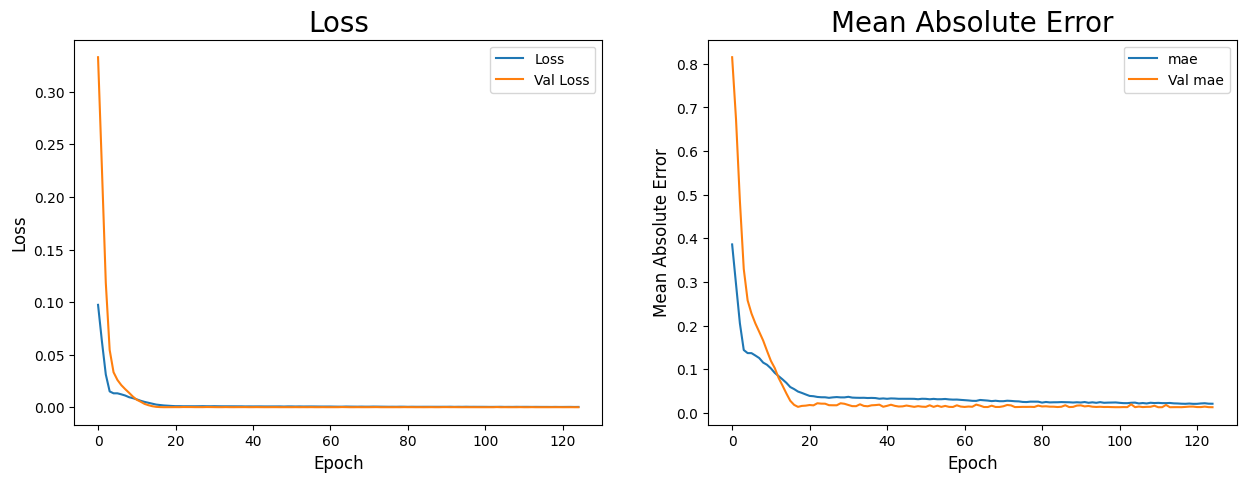

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

5/5 [==============================] - 1s 753us/step


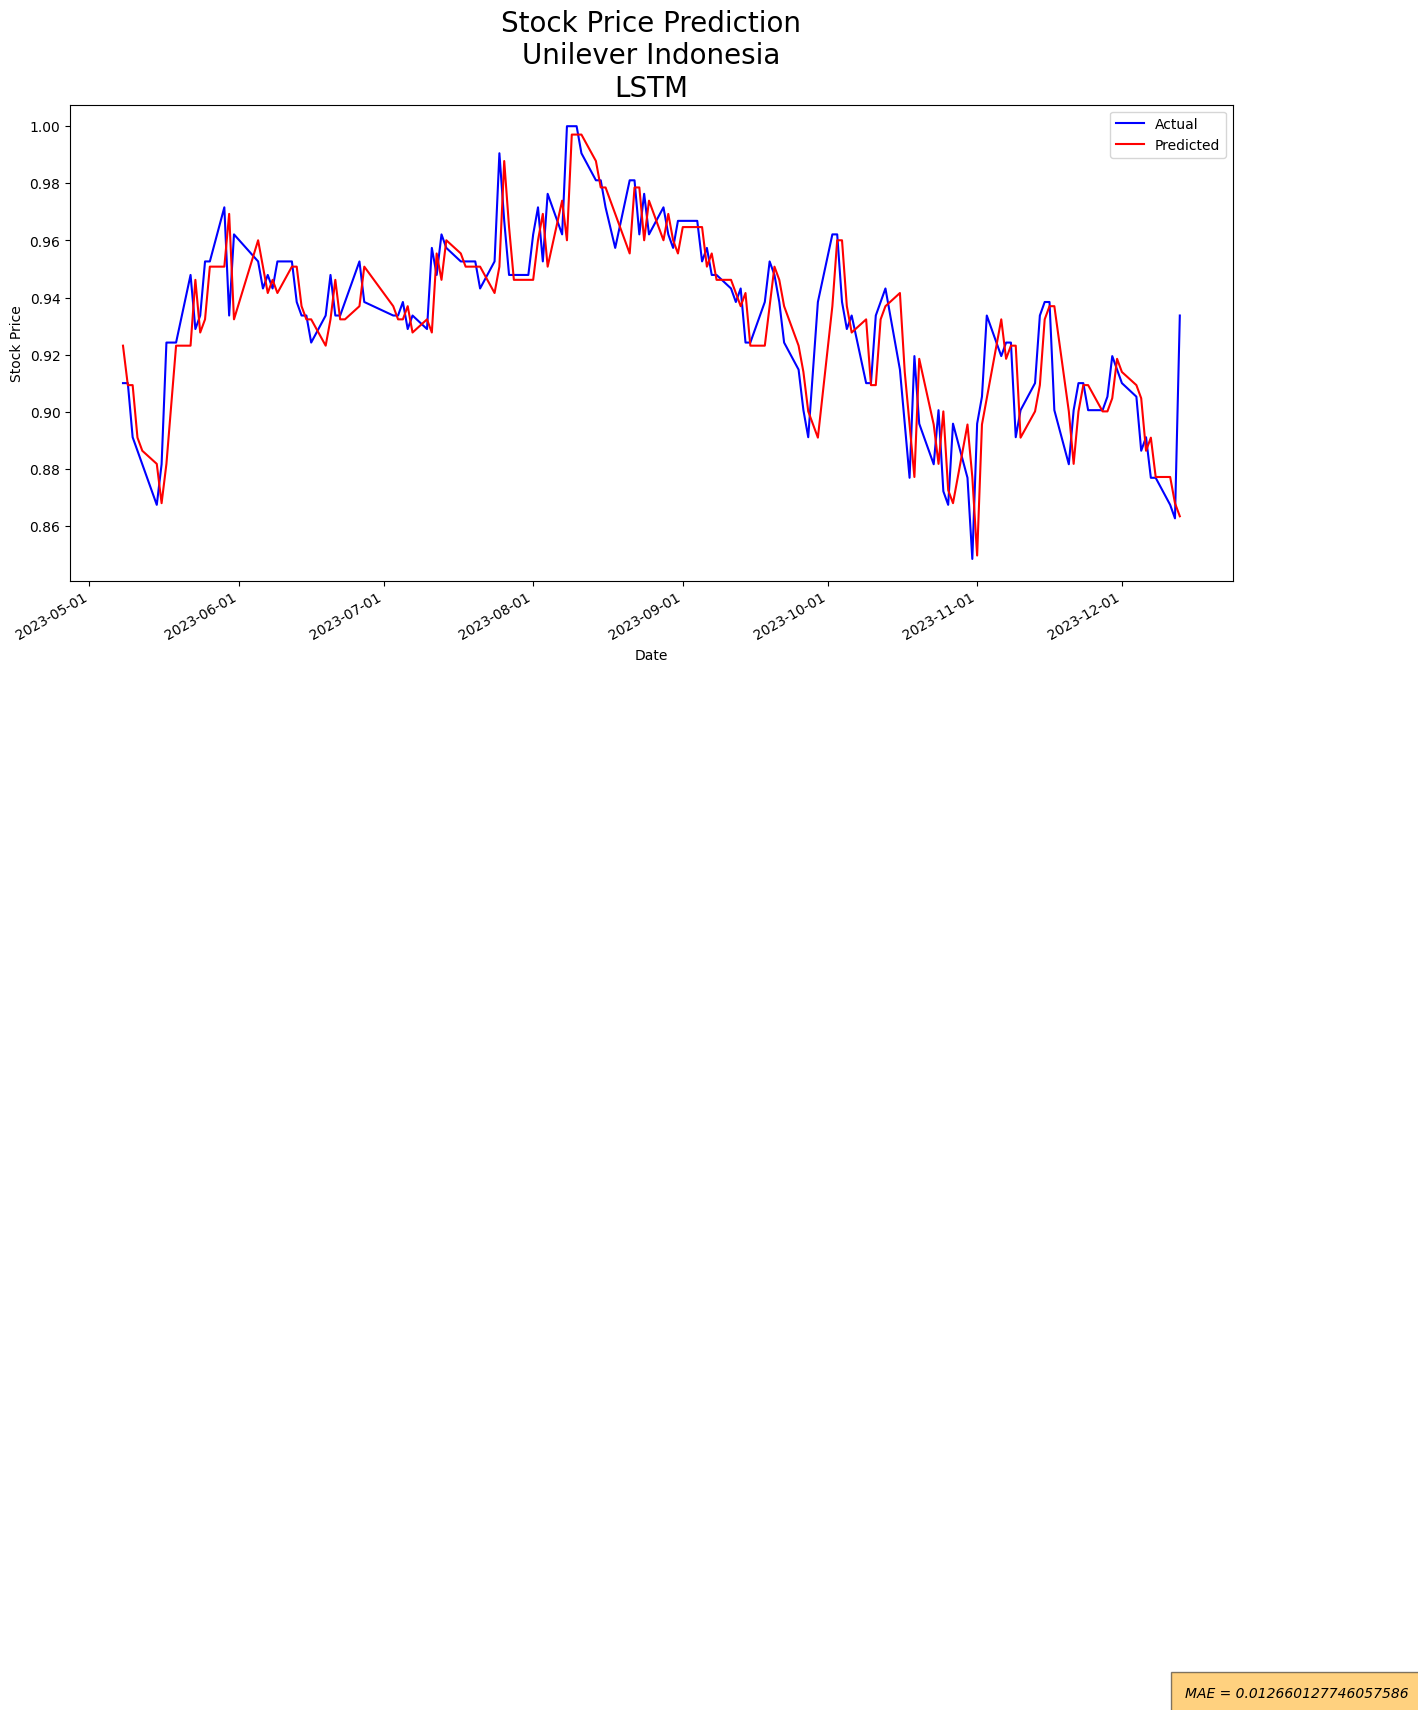

In [73]:
# Perform prediction on the test data
pred = model.predict(X_test)
y_pred = np.array(pred).reshape(-1)

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(test.index[:-1], y_test, color='blue', label='Actual')  # Exclude the last element to match the length
plt.plot(test.index[:-1], y_pred, color='red', label='Predicted')  # Exclude the last element to match the length
plt.text(test.index[149], 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [74]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAE: ', mae)
print('RSME: ', rmse)
print('MAPE: ', mape)

MAE:  0.012660127746057586
RSME:  0.017092984704602895
MAPE:  0.013626948350082803


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1493,) + inhomogeneous part.

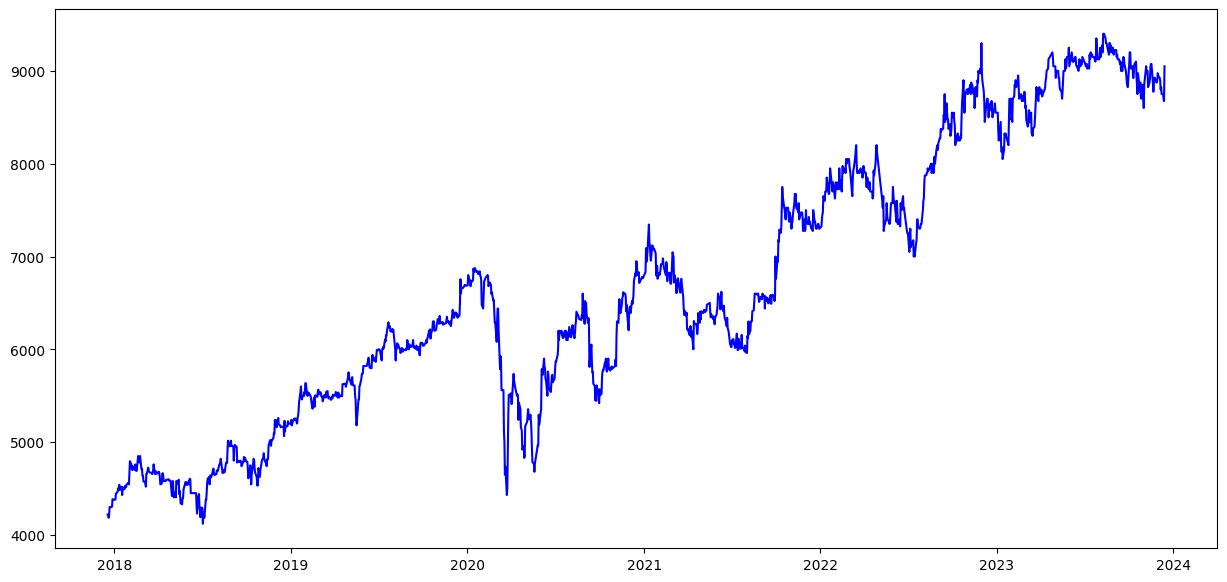

In [75]:
# Inverse transform the predicted values
y_pred_original = ms.inverse_transform(np.array(y_pred).reshape(-1, 1))

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], color='blue', label='Actual')
plt.plot(df.index[:-1], [None] * len(train.index) + list(y_pred_original), color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
# Rotate x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1494,) and (1642,)

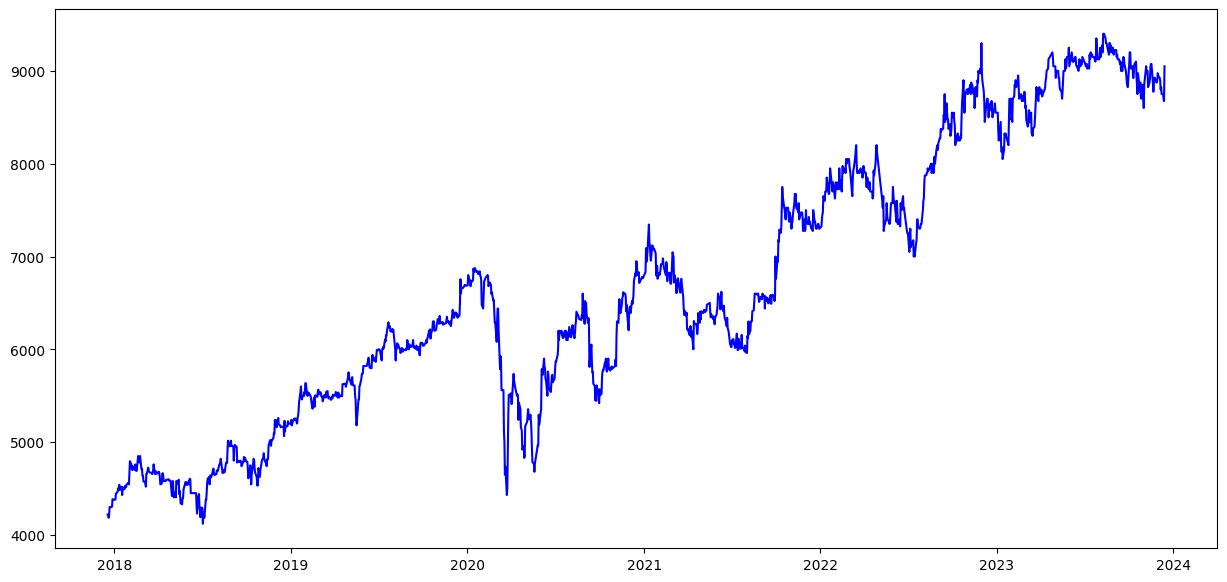

In [76]:
# Buat list kosong untuk menyimpan nilai-nilai yang akan digambarkan
predicted_values = [None] * len(df.index[:-1])  # Buat elemen-elemen "None" sebanyak yang dibutuhkan

# Tambahkan nilai-nilai yang diprediksi ke list predicted_values
predicted_values += list(y_pred_original.flatten())  # Gunakan flatten() untuk mengubah array 2D menjadi 1D

# Plot actual dan predicted prices
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], color='blue', label='Actual')
plt.plot(df.index, predicted_values, color='red', label='Predicted')  # Gunakan predicted_values yang sudah dibuat
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=30)
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (1493,) and (1642,)

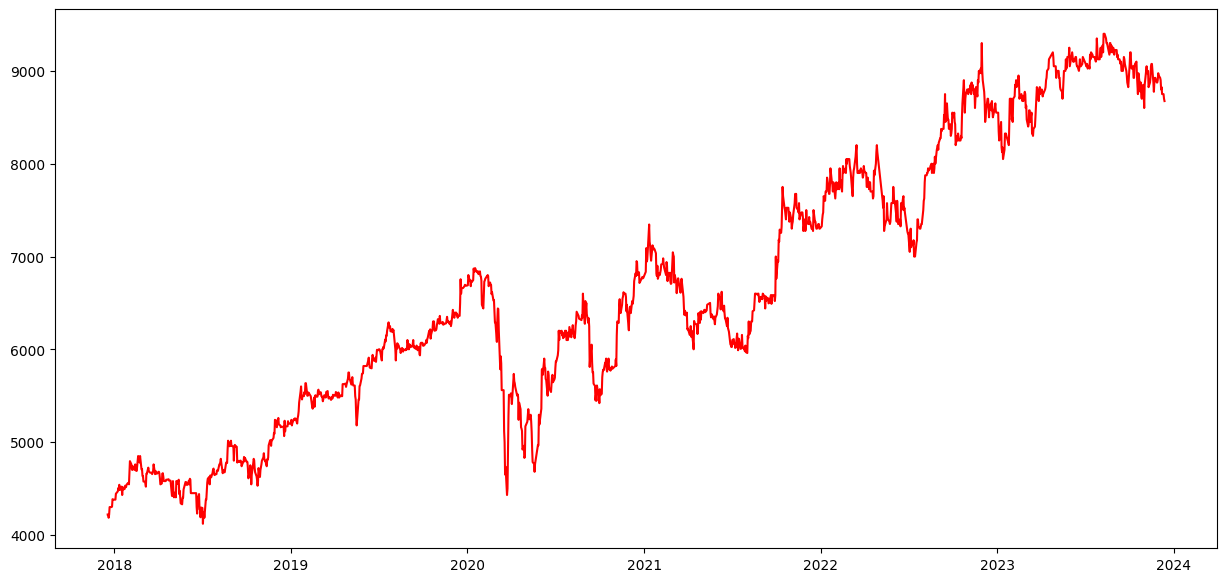

In [81]:
# Buat list indeks baru yang sesuai dengan panjang predicted_values
index_predicted = df.index[:-1]  # Menggunakan indeks yang sesuai dengan panjang predicted_values

# Plot actual dan predicted prices
plt.figure(figsize=(15, 7))
plt.plot(index_predicted, df['Close'][:-1], color='red', label='Actual')  # Menggunakan index_predicted
plt.plot(index_predicted, predicted_values, color='red', label='Predicted')  # Menggunakan predicted_values
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=30)
plt.legend()
plt.show()


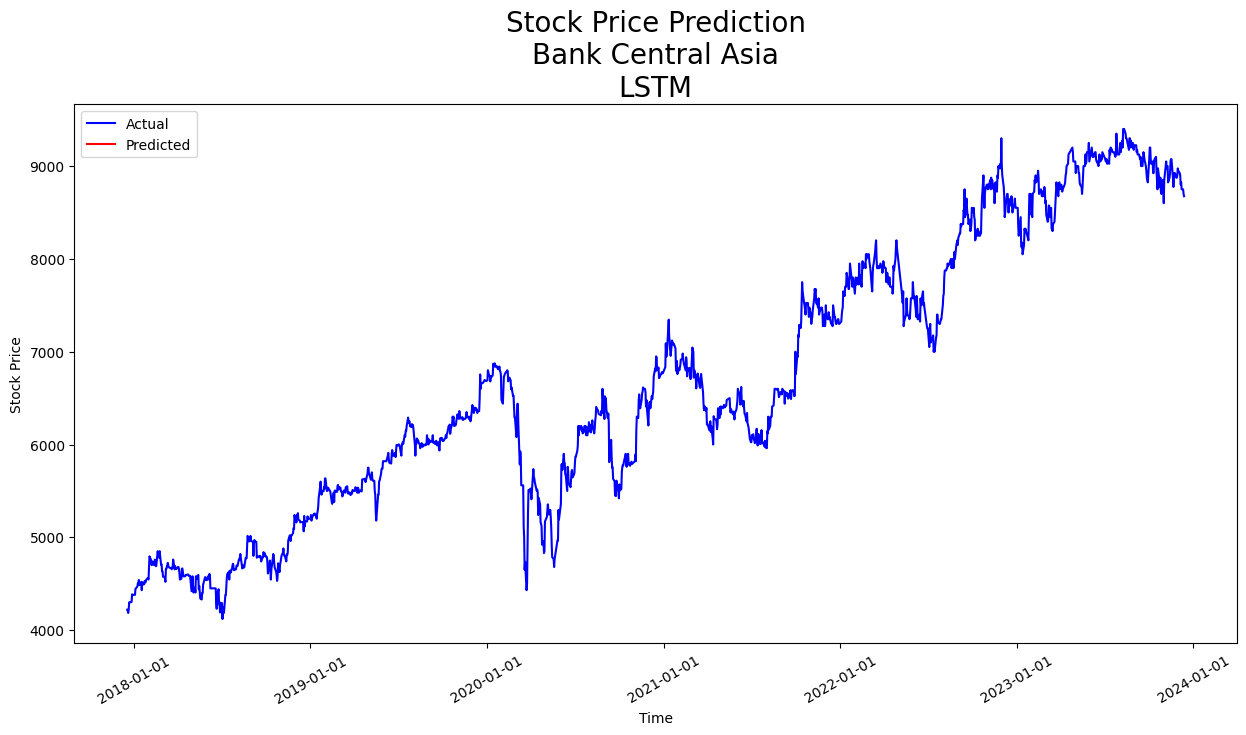

In [83]:
# Menyesuaikan panjang data sumbu x dan y
index_predicted = df.index[:-1]  # Gunakan indeks yang sesuai dengan panjang predicted_values

# Plot actual dan predicted prices
plt.figure(figsize=(15, 7))
plt.plot(index_predicted, df['Close'][:-1], color='blue', label='Actual')  # Gunakan index_predicted
plt.plot(index_predicted, predicted_values[:len(index_predicted)], color='red', label='Predicted')  # Gunakan predicted_values yang disesuaikan panjangnya
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nBank Central Asia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=30)
plt.legend()
plt.show()


In [85]:
# Simpan nilai dari X_test terakhir untuk digunakan dalam prediksi
last_sequence = X_test[-1]

# Buat list untuk menyimpan prediksi
future_predictions = []

# Lakukan prediksi untuk 30 hari ke depan
for i in range(30):
    # Lakukan prediksi untuk satu langkah waktu ke depan
    next_pred = model.predict(last_sequence.reshape(1, 1, 1))[0][0]
    
    # Tambahkan prediksi ke list future_predictions
    future_predictions.append(next_pred)
    
    # Update last_sequence dengan nilai prediksi yang baru untuk digunakan pada iterasi berikutnya
    last_sequence = np.append(last_sequence[1:], next_pred)

# Ubah future_predictions menjadi numpy array
future_predictions = np.array(future_predictions)

# Tampilkan future_predictions
print("Prediksi untuk 30 hari ke depan:")
print(future_predictions)


1/1 [==============================] - 0s 30ms/step
Prediksi untuk 30 hari ke depan:
[0.8634182  0.86412364 0.8648065  0.86546767 0.8661078  0.86672765
 0.8673278  0.86790895 0.8684717  0.8690166  0.8695444  0.87005556
 0.87055063 0.8710302  0.87149477 0.8719447  0.8723806  0.87280285
 0.873212   0.8736083  0.8739923  0.8743643  0.8747248  0.8750741
 0.8754126  0.8757406  0.87605834 0.8763663  0.8766647  0.87695396]


In [89]:
# Denormalisasi future_predictions menggunakan objek MinMaxScaler (ms)
future_predictions_denormalized = ms.inverse_transform(future_predictions.reshape(-1, 1))

# Tampilkan future_predictions_denormalized
print("Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):")
print(future_predictions_denormalized)


Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):
[[8678.848]
 [8682.573]
 [8686.179]
 [8689.669]
 [8693.049]
 [8696.322]
 [8699.49 ]
 [8702.56 ]
 [8705.53 ]
 [8708.408]
 [8711.194]
 [8713.894]
 [8716.507]
 [8719.039]
 [8721.492]
 [8723.868]
 [8726.17 ]
 [8728.398]
 [8730.56 ]
 [8732.652]
 [8734.68 ]
 [8736.644]
 [8738.547]
 [8740.392]
 [8742.179]
 [8743.91 ]
 [8745.588]
 [8747.214]
 [8748.79 ]
 [8750.316]]


In [90]:
import pandas as pd

# Buat DataFrame untuk menyimpan prediksi
predictions_df = pd.DataFrame(future_predictions_denormalized, columns=["Predicted Price"])

# Tambahkan kolom tanggal untuk 30 hari ke depan
last_date = df.index[-1]  # Ambil tanggal terakhir dari data asli
date_range = pd.date_range(start=last_date, periods=30, freq='D')  # Buat rentang tanggal untuk 30 hari ke depan
predictions_df['Date'] = date_range

# Atur kolom tanggal sebagai indeks
predictions_df.set_index('Date', inplace=True)

# Tampilkan DataFrame prediksi
print("Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):")
print(predictions_df)


Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):
            Predicted Price
Date                       
2023-12-14      8678.847656
2023-12-15      8682.573242
2023-12-16      8686.178711
2023-12-17      8689.668945
2023-12-18      8693.048828
2023-12-19      8696.322266
2023-12-20      8699.490234
2023-12-21      8702.559570
2023-12-22      8705.530273
2023-12-23      8708.408203
2023-12-24      8711.194336
2023-12-25      8713.893555
2023-12-26      8716.506836
2023-12-27      8719.039062
2023-12-28      8721.492188
2023-12-29      8723.868164
2023-12-30      8726.169922
2023-12-31      8728.398438
2024-01-01      8730.559570
2024-01-02      8732.652344
2024-01-03      8734.679688
2024-01-04      8736.643555
2024-01-05      8738.546875
2024-01-06      8740.391602
2024-01-07      8742.178711
2024-01-08      8743.910156
2024-01-09      8745.587891
2024-01-10      8747.213867
2024-01-11      8748.790039
2024-01-12      8750.316406
